## Mex Local Rates systematic signals
I am going to explore, which way of constructing the interest rate butterfly produces best trade for mean-reversion strategy with Mexican MBONOs market as a example. I am going to utilise history of fitted zero-coupon curves that I estimated from 12 years of cash bond prices. And construct a dynamic portfolio of bonds for desired target risk profile.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import QuantLib as ql

from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from termcolor import cprint

from src.mbonofirv.systematic.signals import MeanReversionSignal, AggregatedSignal
from src.mbonofirv.systematic.strategies import SystematicStrategy
from src.mbonofirv.systematic.estimation import (
    get_pca_bf_weights,
    fit_ou_params,
    load_historical_data,
)

plt.style.use("ggplot")

In [24]:
def signal_comparison(
    signals,
    signal_types,
    df_zc,
    df_instruments,
    df_prices,
    df_fit,
    vol_adjustment=False,
):
    fig, ax = plt.subplots(
        4, 1, figsize=(20, 20), gridspec_kw={"height_ratios": [2, 1, 1, 1]}
    )
    ax[0].title.set_text("Raw signal Performance")
    ax[0].xaxis.set_label_text("Date")
    ax[0].yaxis.set_label_text("DV01 points")
    signal_stats = pd.DataFrame(
        index=signal_types, columns=["Gross Sharpe", "Net Sharpe", "Daily Turnover"]
    )
    for i in range(len(signal_types)):
        aggregated_signal = AggregatedSignal(signals[i], dates=df_zc.loc["2015":].index)
        aggregated_signal.estimate_target_risk()
        if vol_adjustment:
            aggregated_signal.set_target_volatility(1, df_zc)
        pnl = 10000 * aggregated_signal.dumb_pnl(df_zc.loc["2015":])
        ax[0].plot(pnl.cumsum())
        strategy = SystematicStrategy(
            aggregated_signal, df_instruments, df_prices, df_zc, fit_resid=df_fit
        )
        strategy.calc_position()
        strategy.calc_total_pnl()
        signal_stats.loc[signal_types[i], "Gross Sharpe"] = (
            np.sqrt(261)
            * strategy.pnl.sum(axis=1).mean()
            / strategy.pnl.sum(axis=1).std()
        )
        ax[i + 1].plot(strategy.pnl.sum(axis=1).cumsum())
        strategy.calc_total_pnl(0.00005)
        ax[i + 1].plot(strategy.pnl.sum(axis=1).cumsum())
        ax[i + 1].title.set_text(signal_types[i] + " strategy PnL")
        ax[i + 1].xaxis.set_label_text("Date")
        ax[i + 1].yaxis.set_label_text("PnL, $")
        ax[i + 1].legend(["Gross", "Net"])
        signal_stats.loc[signal_types[i], "Net Sharpe"] = (
            np.sqrt(261)
            * strategy.pnl.sum(axis=1).mean()
            / strategy.pnl.sum(axis=1).std()
        )
        turnover = (strategy.trades * strategy.dirty_prices).abs().sum(axis=1).sum() / (
            strategy.position * strategy.dirty_prices
        ).abs().sum(axis=1).sum()
        signal_stats.loc[signal_types[i], "Daily Turnover"] = turnover
    ax[0].legend(signal_types, loc="best")
    plt.show()
    return signal_stats

Setting MBONO market conventions

In [25]:
CONVENTION = ql.Unadjusted
CALENDAR = ql.Mexico()
YIELD_BASIS = ql.Semiannual
TENOR = ql.Period(ql.Semiannual)
RULE = ql.DateGeneration.Backward
DAY_COUNT = ql.Actual360()
SETTLEMENT_DAYS = 2

Loading all the neccesarry data: zero curves, instruments, prices etc

Source of fitted curves and estimation: https://github.com/akaufman22/mbono-firv

In [26]:
df_zc, df_instruments, df_prices, df_fit = load_historical_data(
    db_path="./db/MBONOdata.db", print_head=True
)

Curves


,Y1,Y2,Y3,Y5,Y7,Y10,Y15,Y20,Y30
Date,,,,,,,,,
2010-01-01 00:00:00,0.049139,0.059082,0.066124,0.074606,0.079008,0.082525,0.086468,0.090251,0.096812
2010-01-04 00:00:00,0.048706,0.059136,0.066494,0.075229,0.079574,0.082800,0.086405,0.090291,0.097765
2010-01-05 00:00:00,0.051110,0.058690,0.066621,0.075089,0.079097,0.082451,0.086078,0.089435,0.098320
2010-01-06 00:00:00,0.050152,0.059206,0.066920,0.074806,0.078709,0.082246,0.086287,0.089779,0.097143
2010-01-07 00:00:00,0.048686,0.059434,0.066632,0.074840,0.078968,0.082336,0.086170,0.089791,0.096544


Instruments


,InstrumentID,Maturity,PricingDate,QL bond
BBGID,,,,
EC4262522 Corp,6,2011-07-14 00:00:00,2001-07-20 00:00:00,*' at 0x7ff717e4dfc0> >
EC6223613 Corp,10,2009-07-09 00:00:00,2002-07-12 00:00:00,*' at 0x7ff717e77db0> >
EC8045386 Corp,12,2009-12-24 00:00:00,2002-12-27 00:00:00,*' at 0x7ff6fdfe0bd0> >
EC8084633 Corp,13,2012-12-20 00:00:00,2003-01-03 00:00:00,*' at 0x7ff71804fde0> >
ED2028832 Corp,15,2023-12-07 00:00:00,2003-10-24 00:00:00,*' at 0x7ff71799c840> >


Prices


,EC4262522 Corp,EC8045386 Corp,EC8084633 Corp,ED2028832 Corp,ED2746086 Corp,ED2816525 Corp,ED7597518 Corp,ED7791103 Corp,ED7894840 Corp,EF2270975 Corp,EF5478096 Corp,EF5805942 Corp,EF7918115 Corp,EG1116375 Corp,EG1429968 Corp,EG6663686 Corp,EH1850997 Corp,EH6834517 Corp,EH6944449 Corp,EH7175118 Corp,EH9108950 Corp,EI1588082 Corp,EI3157795 Corp,EI5616079 Corp,EI7570381 Corp,EI8047355 Corp,BO5734625 Corp,BO5786427 Corp,EJ0234298 Corp,EJ1291206 Corp,EJ2827917 Corp,EJ8068490 Corp,EK1693424 Corp,EI7361336 Corp,QJ1649335 Corp,AM7523740 Corp,AS2511341 Corp,AX6352725 Corp,ZR8833868 Corp,BR4592233 Corp,BS4948482 Corp,BX4963407 Corp,ZK9254374 Corp,YT7609787 Corp,ZI4289875 Corp,ZN7935812 Corp,ZJ8065048 Corp
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,108.040000,100.011000,106.456000,97.457000,102.788000,103.646000,109.157000,114.879000,106.560000,102.930000,106.430000,104.380000,113.645000,91.109000,97.763000,102.350000,99.320000,99.151000,97.116000,103.246000,98.980000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-04 00:00:00,108.045000,100.011000,106.240000,97.553000,102.804000,103.390000,108.919000,114.605000,106.521000,102.383000,106.486000,104.404000,113.361000,90.906000,97.623000,102.400000,99.185000,98.941000,96.780000,103.126000,98.952000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-05 00:00:00,108.057000,100.011000,106.251000,97.814000,102.790000,103.383000,108.901000,114.911000,106.493000,102.395000,106.549000,104.393000,113.795000,91.156000,97.648000,102.382000,99.257000,99.248000,97.130000,103.311000,99.040000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-06 00:00:00,108.099000,100.011000,106.317000,97.862000,102.783000,103.377000,108.945000,115.047000,106.483000,102.438000,106.564000,104.383000,113.972000,91.346000,97.698000,102.371000,99.278000,99.488000,97.302000,103.437000,99.042000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-07 00:00:00,108.074000,100.011000,106.421000,97.907000,102.771000,103.481000,109.026000,114.992000,106.471000,102.539000,106.631000,104.359000,114.077000,91.408000,97.784000,102.474000,99.322000,99.579000,97.389000,103.483000,99.195000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Fitted Residuals


,EC4262522 Corp,EC8084633 Corp,ED2028832 Corp,ED2746086 Corp,ED2816525 Corp,ED7597518 Corp,ED7791103 Corp,ED7894840 Corp,EF2270975 Corp,EF5478096 Corp,EF5805942 Corp,EF7918115 Corp,EG1116375 Corp,EG1429968 Corp,EG6663686 Corp,EH1850997 Corp,EH6834517 Corp,EH6944449 Corp,EH7175118 Corp,EH9108950 Corp,EI1588082 Corp,EI3157795 Corp,EI5616079 Corp,EI7570381 Corp,EI8047355 Corp,BO5734625 Corp,BO5786427 Corp,EJ0234298 Corp,EJ1291206 Corp,EJ2827917 Corp,EJ8068490 Corp,EK1693424 Corp,EI7361336 Corp,QJ1649335 Corp,AM7523740 Corp,AS2511341 Corp,AX6352725 Corp,ZR8833868 Corp,BR4592233 Corp,BS4948482 Corp,BX4963407 Corp
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,-0.004205,0.000866,0.000246,0.001868,-0.000460,-0.000070,-0.000353,-0.003555,-0.001657,0.001410,0.000003,-0.000116,0.000165,-0.000737,0.002547,0.000063,0.000709,0.000137,0.000450,0.000848,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-04 00:00:00,-0.004120,0.001318,-0.000007,0.002118,-0.000227,-0.000095,-0.000196,-0.003388,-0.001114,0.000812,0.000012,-0.000155,0.000309,-0.001018,0.002148,-0.000191,0.000805,0.000133,0.000220,0.000379,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-05 00:00:00,-0.004285,0.001036,-0.000109,-0.000957,-0.000428,-0.000060,-0.000277,-0.003048,-0.000915,0.000322,-0.000009,-0.000111,0.000395,-0.000722,0.002224,0.000040,0.000940,0.000094,0.000251,0.000053,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-06 00:00:00,-0.004713,0.000510,-0.000162,0.000188,-0.000374,0.000061,-0.000439,-0.003443,-0.000682,0.000156,-0.000002,-0.000204,0.000063,-0.000470,0.001842,0.000326,0.000571,0.000084,0.000333,0.000209,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-07 00:00:00,-0.004839,0.000492,-0.000138,0.002286,-0.000367,-0.000046,-0.000309,-0.003523,-0.000962,0.000314,-0.000017,-0.000239,0.000052,-0.000771,0.001614,0.000116,0.000508,0.000107,0.000165,0.000005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


I produce signals based on mean-reversion of butterflies. Estimation set is rolling five years lookback period. Test set is rolling one year forward period. Three methods of butterfly weighting are used: baseline duration weighted, weights generated by the Johansen procedure and PCA-based (applied to levels)

In [27]:
tenors = ["Y2", "Y3", "Y5", "Y7", "Y10", "Y15", "Y20"]

lookback_years = 5
test_years = 1
p_val_crit = 0.1
hl_crit = 30
sigma_crit = 0.0003
z_ol = -2
z_cl = -0.5
z_os = 2
z_cs = 0.5

eoy = pd.date_range(end=df_zc.index[-1], start=df_zc.index[0], freq="BY")
dv_bf_weights = np.array([-0.5, 1.0, -0.5]).reshape(-1, 1)
dv_signals = []
pca_signals = []
jo_signals = []

for i in tqdm(range(lookback_years - 1, len(eoy), 1)):
    idx = pd.bdate_range(
        start=eoy[i] + pd.tseries.offsets.DateOffset(years=-lookback_years), end=eoy[i]
    )
    train_idx = df_zc.index.intersection(idx)
    idx = pd.bdate_range(
        end=eoy[i] + pd.tseries.offsets.DateOffset(years=test_years),
        start=eoy[i] + pd.tseries.offsets.DateOffset(days=1),
    )
    test_idx = df_zc.index.intersection(idx)
    for j, t1 in enumerate(tenors):
        for k, t2 in enumerate(tenors[j + 1 : j + 2]):
            for t3 in tenors[j + k + 2 : j + k + 3]:
                dv_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(dv_bf_weights)
                if adfuller(dv_bf_ts)[1] < p_val_crit:
                    _, mu, sigma_eq, hl = fit_ou_params(dv_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        dv_bf_test = df_zc.loc[test_idx, [t1, t2, t3]].dot(
                            dv_bf_weights
                        )
                        dv_signal = MeanReversionSignal(
                            [t1, t2, t3], dv_bf_weights, dv_bf_test, mu, sigma_eq
                        )
                        dv_signal.set_trading_rule(
                            ol=z_ol, cl=z_cl, os=z_os, cs=z_cs, ts=30
                        )
                        dv_signals.append(dv_signal)
                pca_bf_weights = get_pca_bf_weights(df_zc.loc[train_idx, [t1, t2, t3]])
                pca_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(pca_bf_weights)
                if adfuller(pca_bf_ts)[1] < p_val_crit:
                    _, mu, sigma_eq, hl = fit_ou_params(pca_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        pca_bf_test = df_zc.loc[test_idx, [t1, t2, t3]].dot(
                            pca_bf_weights
                        )
                        pca_signal = MeanReversionSignal(
                            [t1, t2, t3], pca_bf_weights, pca_bf_test, mu, sigma_eq
                        )
                        pca_signal.set_trading_rule(
                            ol=z_ol, cl=z_cl, os=z_os, cs=z_cs, ts=30
                        )
                        pca_signals.append(pca_signal)
                johansen = coint_johansen(
                    df_zc.loc[train_idx, [t1, t2, t3]], det_order=1, k_ar_diff=1
                )
                if (johansen.lr1[0] > johansen.cvt[0, 1]) & (
                    johansen.lr2[0] > johansen.cvm[0, 1]
                ):
                    jo_bf_weights = (johansen.evec[:, 0] / johansen.evec[1, 0]).reshape(
                        -1, 1
                    )
                    jo_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(jo_bf_weights)
                    _, mu, sigma_eq, hl = fit_ou_params(jo_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        jo_bf_test = df_zc.loc[test_idx, [t1, t2, t3]].dot(
                            jo_bf_weights
                        )
                        jo_signal = MeanReversionSignal(
                            [t1, t2, t3], jo_bf_weights, jo_bf_test, mu, sigma_eq
                        )
                        jo_signal.set_trading_rule(
                            ol=z_ol, cl=z_cl, os=z_os, cs=z_cs, ts=30
                        )
                        jo_signals.append(jo_signal)

100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


To assess signal quality I do a backtest of three unoptimized trading strategies, each utilising single type of butterfly construction method. Assumptions here are fixed (per unit of risk) transaction cost, zero slippage and cost of funding defined by short-end rate.
First we compare performance when adding signals of same type together:

Simple aggregation of signals
Aggregating Signals
Calculating Position


100%|██████████| 2607/2607 [04:40<00:00,  9.31it/s]


Aggregating Signals
Calculating Position


100%|██████████| 2607/2607 [10:22<00:00,  4.18it/s]


Aggregating Signals
Calculating Position


100%|██████████| 2607/2607 [12:37<00:00,  3.44it/s]


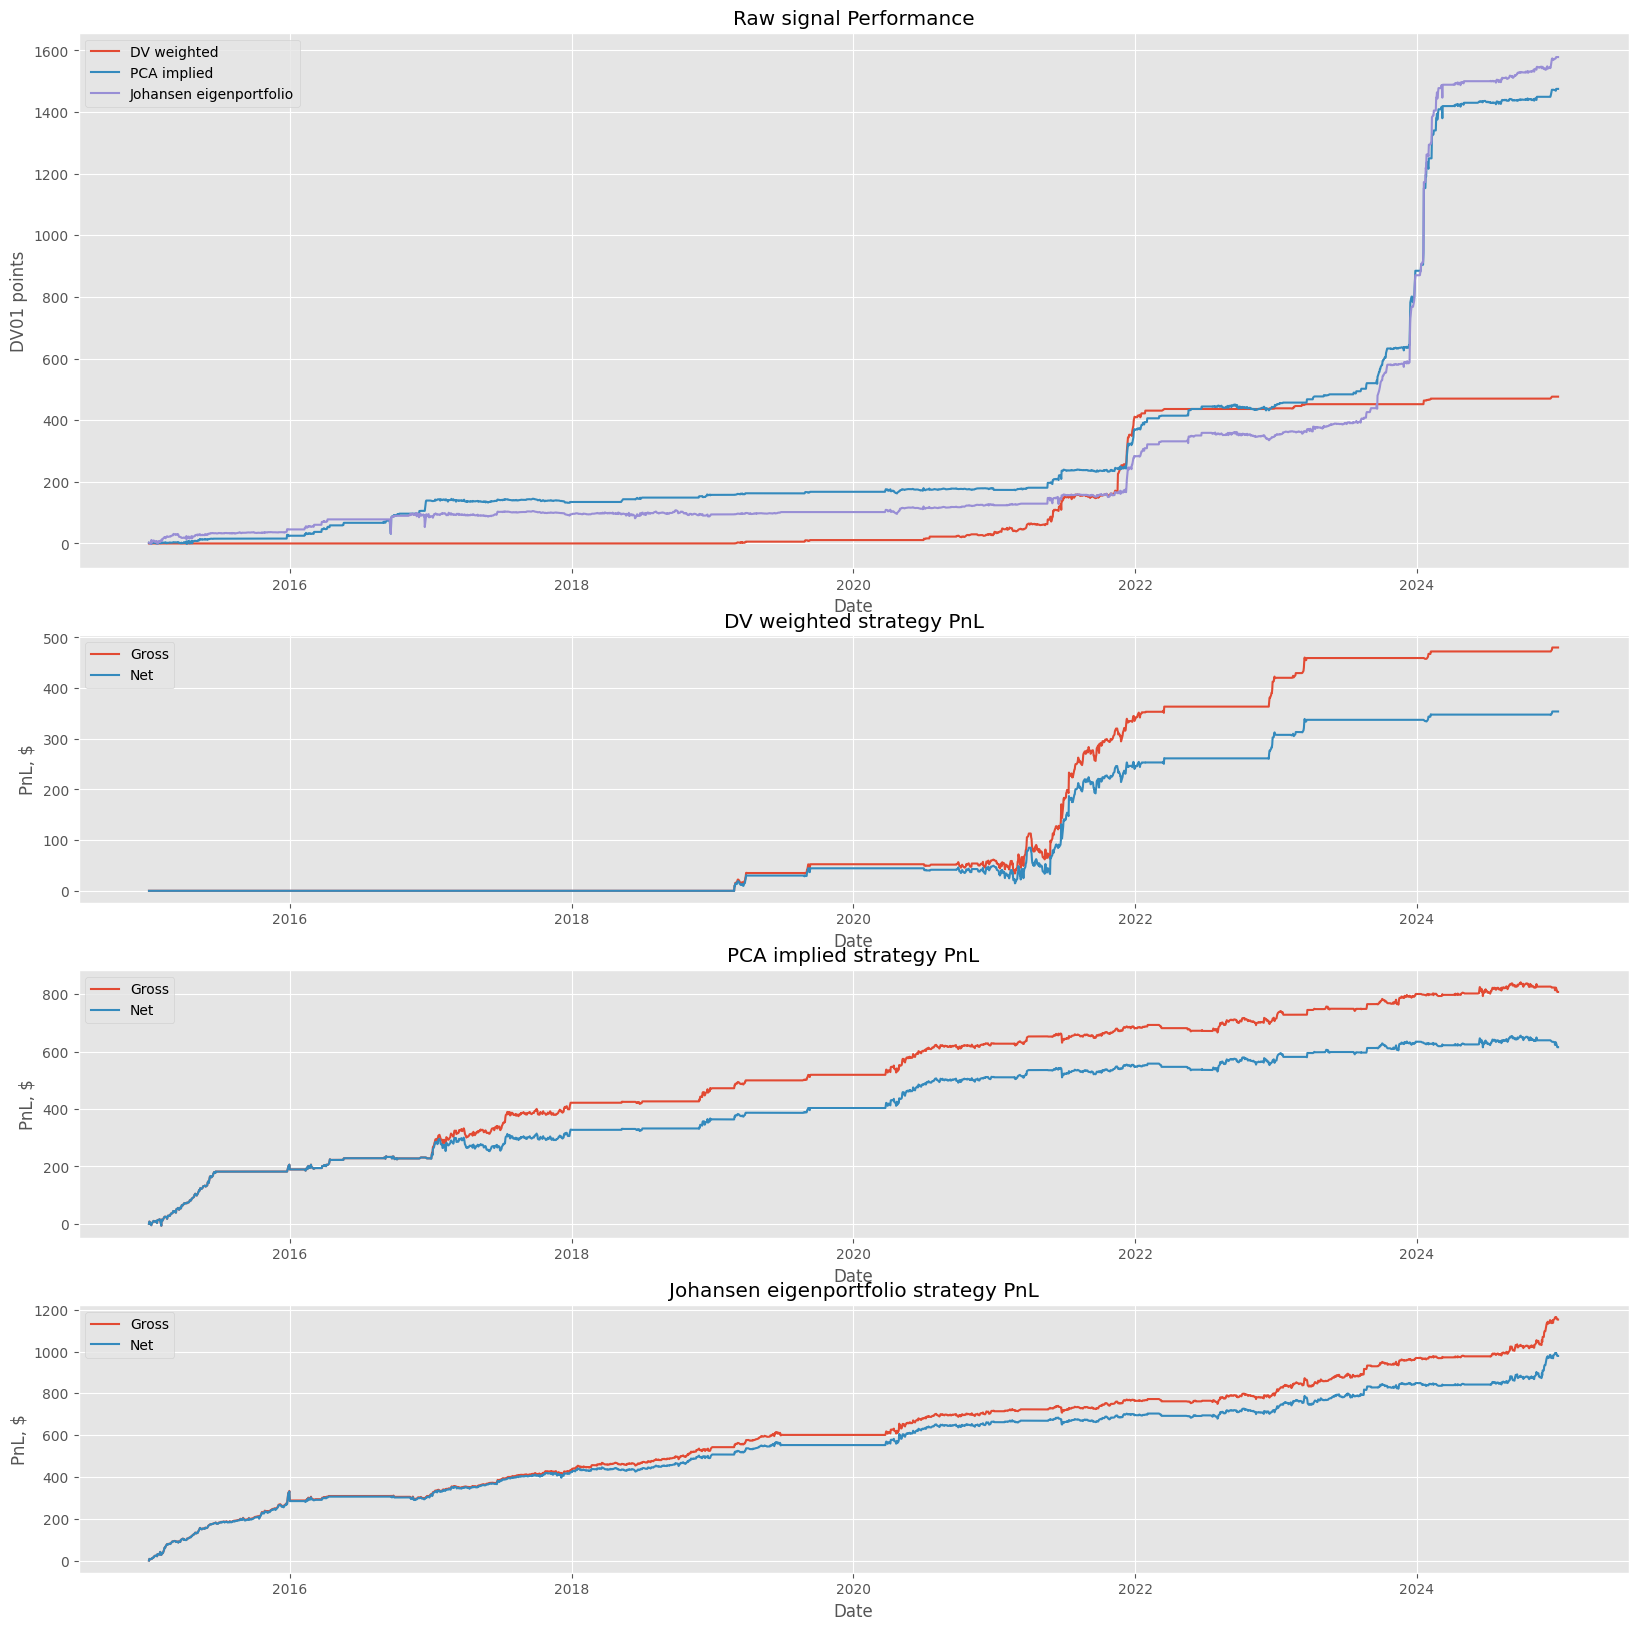

,Gross Sharpe,Net Sharpe,Daily Turnover
DV weighted,1.27,0.96,39.38%
PCA implied,1.63,1.25,41.18%
Johansen eigenportfolio,2.00,1.71,38.13%


In [28]:
signal_types = ["DV weighted", "PCA implied", "Johansen eigenportfolio"]
signals = [dv_signals, pca_signals, jo_signals]
cprint(("Simple aggregation of signals".center(24)), "green", attrs=["bold"])
signal_stats = signal_comparison(
    signals,
    signal_types,
    df_zc,
    df_instruments,
    df_prices,
    df_fit,
    vol_adjustment=False,
)
signal_stats.style.format(
    {"Gross Sharpe": "{:.2f}", "Net Sharpe": "{:.2f}", "Daily Turnover": "{:.2%}"}
)

Johansen provides better Sharpe. However, above is not exactly apple-to-apple comparison. Also, this strategy produces very variable risk profile and probabaly inconsistant with risk limits and the neccessity to deploy capital.

Much more realistic case of strategies based on constant signal volatility:

Aggregation of signals with volatility adjustment
Aggregating Signals
Setting Target Volatility


100%|██████████| 2608/2608 [00:27<00:00, 93.92it/s] 


Calculating Position


100%|██████████| 2607/2607 [03:25<00:00, 12.68it/s]


Aggregating Signals
Setting Target Volatility


100%|██████████| 2608/2608 [00:20<00:00, 128.99it/s]


Calculating Position


100%|██████████| 2607/2607 [05:30<00:00,  7.88it/s]


Aggregating Signals
Setting Target Volatility


100%|██████████| 2608/2608 [00:26<00:00, 97.79it/s] 


Calculating Position


100%|██████████| 2607/2607 [07:30<00:00,  5.79it/s]


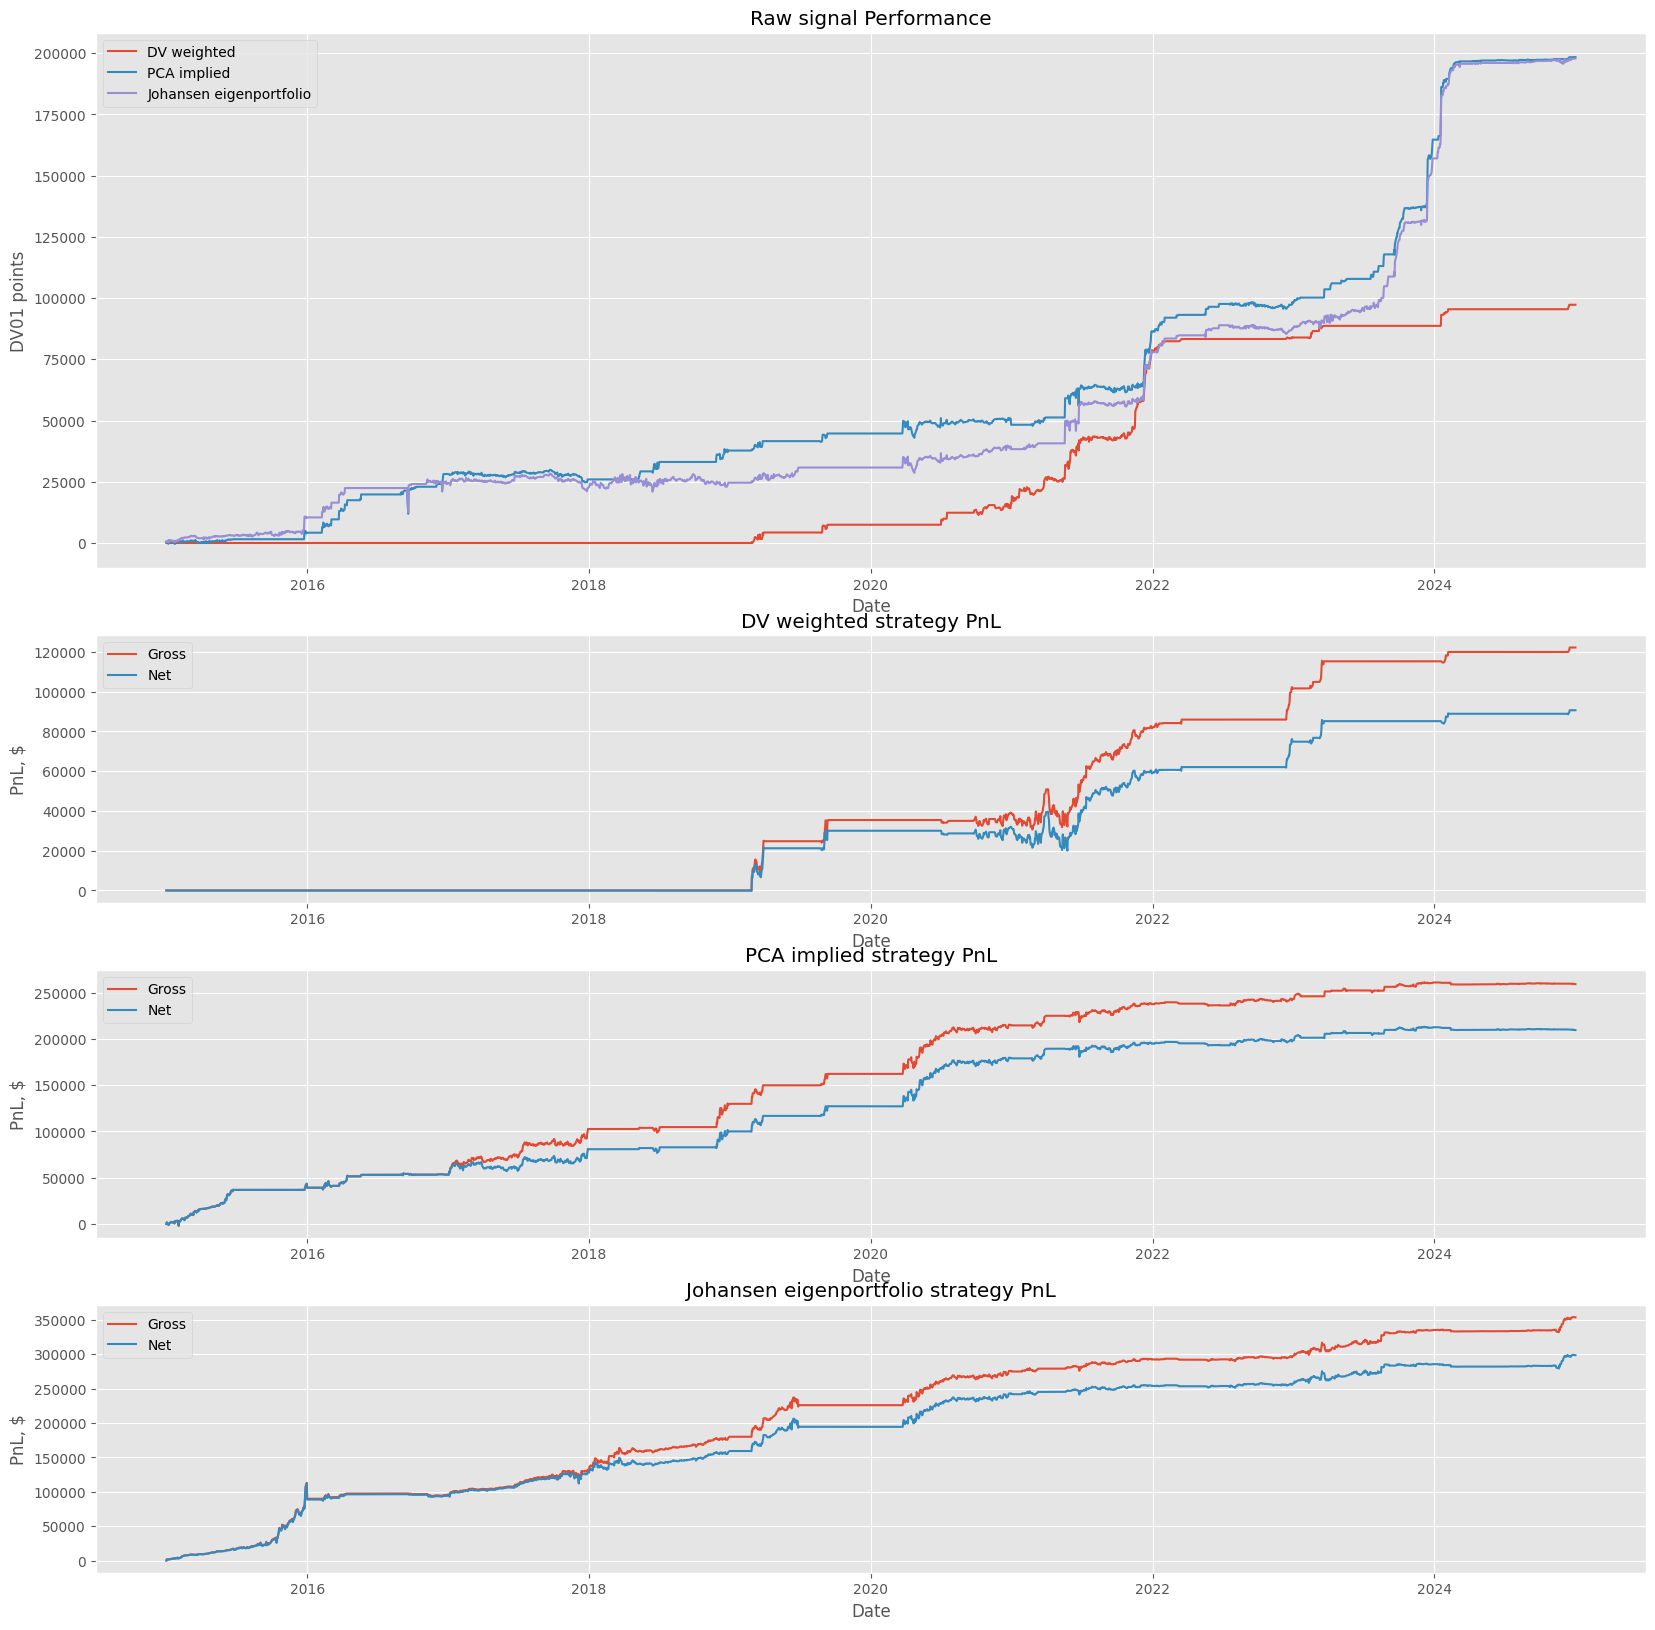

,Gross Sharpe,Net Sharpe,Daily Turnover
DV weighted,1.22,0.93,40.10%
PCA implied,1.66,1.36,42.45%
Johansen eigenportfolio,1.56,1.32,44.39%


In [22]:
cprint(
    ("Aggregation of signals with volatility adjustment".center(24)),
    "green",
    attrs=["bold"],
)
signal_stats = signal_comparison(
    signals, signal_types, df_zc, df_instruments, df_prices, df_fit, vol_adjustment=True
)
signal_stats.style.format(
    {"Gross Sharpe": "{:.2f}", "Net Sharpe": "{:.2f}", "Daily Turnover": "{:.2%}"}
)

In this case PCA looks slightly better overall although statistically Sharpe ratios for PCA and Johansen are probably indistinguishable on realistic sample size.